In [11]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji
from matplotlib import pyplot as plt
import math
from joblib import dump, load

stop_words = set(stopwords.words("english"))


In [6]:
fn = "group_8_automotive_data.csv"
data = pd.read_csv(fn, encoding='utf-8')

In [7]:
from nltk.corpus import wordnet

def negate(sentence):	
  '''
  Input: Tokenized sentence (List of words)
  Output: Tokenized sentence with negation handled (List of words)
  '''
  temp = int(0)
  for i in range(len(sentence)):
      if sentence[i-1] in ['not',"n't"]:
          antonyms = []
          for syn in wordnet.synsets(sentence[i]):
              syns = wordnet.synsets(sentence[i])
              w1 = syns[0].name()
              temp = 0
              for l in syn.lemmas():
                  if l.antonyms():
                      antonyms.append(l.antonyms()[0].name())
              max_dissimilarity = 0
              for ant in antonyms:
                  syns = wordnet.synsets(ant)
                  w2 = syns[0].name()
                  syns = wordnet.synsets(sentence[i])
                  w1 = syns[0].name()
                  word1 = wordnet.synset(w1)
                  word2 = wordnet.synset(w2)
                  if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                      temp = 1 - word1.wup_similarity(word2)
                  if temp>max_dissimilarity:
                      max_dissimilarity = temp
                      antonym_max = ant
                      sentence[i] = antonym_max
                      sentence[i-1] = ''
  while '' in sentence:
      sentence.remove('')
  return sentence

negate(["not", "good"])

['evil']

In [8]:
def cleanly_tokenize(text):
  # Remove URLs
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)
  
  # Remove HTML tags by getting parsed text
  text = BeautifulSoup(text, "html.parser").get_text()

  # Replace "n't" with " not"
  text = re.sub(r"n't", " not", text)

  # Remove non-letters (except emojis) and lowercase 
  pattern = r'[^a-zA-Z\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+'
  text = re.sub(pattern, " ", text).lower()
  
  # Replace emojis with text representation
  text = emoji.demojize(text, ["emoji_", " "])

  # Tokenize
  tokens = word_tokenize(text)
  
  # Handle negation
  tokens = negate(tokens)

  # Remove stopwords
  tokens = [i for i in tokens if i not in stop_words]

  # Remove tokens of length 1
  tokens = [i for i in tokens if len(i) > 1]

  # Stem
  stemmer = nltk.WordNetLemmatizer()
  tokens = [stemmer.lemmatize(i) for i in tokens]

  return tokens


In [5]:
cleanly_tokenize("It didn't fit my steering wheel. I returned 3 of them 😕")

['unfit', 'steering', 'wheel', 'returned', 'emoji_confused_face']

In [315]:
# find all rows that have emoji in review_body
data[data['review_body'].str.contains('[\U0001F600-\U0001F6FF]')]["review_body"].sample(10).values

array(['Great product. Great price! Great shopping speed 😊',
       'I order this bling bling spankleling dimon plate for my camary and was excited to put it on my car but not 1 day has pass when I already lost a few dimons, the cap are really cheap😔💀',
       'awesome 👍👍😃',
       "It didn't fit my steering wheel. I returned 3 of them 😕",
       'Awesome!😀',
       'Item arrived much earlier than expected, and was in perfect condition and exactly as described!<br />Kudos! 😊👍',
       'Very happy with product!<br />Looks and feels excellent  😀',
       'Arrived on time! I Loved the kit it made my car appear like new when I attached the decals to my center console. Would highly recommended. Also, remember to use a hair dryer when applying the decals. The hair dryer does the trick in the end😁',
       'The lights are awesome, as was the speed in which they got here, but the color seems more purple than my blue led lighting in the vehicle still great the tutorial video on YouTube was VERY

In [ ]:
def get_review_body(review_id):
  return cleanly_tokenize(data.loc[data["review_id"] == review_id]["review_body"].values[0])

get_review_body("R1CKCTN2BXKOBQ")

['work', 'great', 'emoji_grinning_face', 'emoji_grinning_face']

In [29]:
trunc = data.sample(70000)
trunc['review_body'].head(10)

227408    Decent,  except the temperature part sometimes...
210753    Fit our 2015 Honda Pilot very nice. Installed ...
121711    I was expecting a thicker product - more like ...
175153                                Just like the picture
243902    ARRIVED SUPER FAST!!! To those who gave this i...
118355    Followed the directions perfectly and I can st...
70905     Love it. Got for the hatch for the cuddy on bo...
281626    For the price, you won't find anything better....
279631                               Seems to jump anything
332295    This is a simple scanner that can be used by m...
Name: review_body, dtype: object

In [9]:
# give me 10k random one star reviews
def get_by_star(star, n):
    return data[data["star_rating"] == star].sample(math.ceil(n))


def get_weights(t):
    base = [
        0.085047405,
        0.0387409,
        0.062817448,
        0.136370552,
        0.677023695,
    ]

    return [i * (1 - t) + 0.2 * t for i in base]


# using get_by_star give me one dataframe with equal amounts of star reviews
def get_equal_star(n, t):
    weights = get_weights(t)
    one = get_by_star(1, n * weights[0])
    two = get_by_star(2, n * weights[1])
    three = get_by_star(3, n * weights[2])
    four = get_by_star(4, n * weights[3])
    five = get_by_star(5, n * weights[4])
    return pd.concat([one, two, three, four, five]).sample(n)


# get data rows not in trunc
def get_not_trunc(trunc):
    return data.loc[~data["review_id"].isin(trunc["review_id"])]


def get_data(n, k, t):
    train = get_equal_star(n, t)
    print(train["star_rating"].value_counts())
    test = get_not_trunc(train).sample(k)
    return pd.concat([train, test])


trunc = get_data(50000, 10000, 0.75)


5    15961
4     9205
1     8563
3     8286
2     7985
Name: star_rating, dtype: int64


In [10]:
vectorizer = TfidfVectorizer(
  # stop_words="english", 
  # strip_accents="unicode", 
  # lowercase=True, 
  tokenizer=cleanly_tokenize,
  ngram_range=(1, 1), 
  max_features=10000
)

counts = vectorizer.fit_transform(trunc["review_body"]).toarray()
words = vectorizer.get_feature_names_out()
print(words)

# print words that contain _ (emojis)
print([word for word in words if "emoji_" in word])

df_tf_idf = pd.DataFrame(counts, columns=words)

# don't do .todense()?


c:\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Qcoret\AppData\Roaming\Python\Python310\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


['aa' 'aaa' 'aaaa' ... 'zuma' 'zx' 'zzw']
['emoji_OK_hand', 'emoji_OK_hand_medium-light_skin_tone', 'emoji_angry_face', 'emoji_confused_face', 'emoji_downcast_face_with_sweat', 'emoji_grinning_face', 'emoji_grinning_face_with_big_eyes', 'emoji_smiling_face_with_smiling_eyes', 'emoji_smiling_face_with_sunglasses', 'emoji_thumbs_down', 'emoji_thumbs_down_light_skin_tone', 'emoji_thumbs_up', 'emoji_thumbs_up_light_skin_tone', 'emoji_thumbs_up_medium-light_skin_tone']


In [12]:
dump(df_tf_idf, "50k_10k_tf_idf_75pc.joblib")

['50k_10k_tf_idf_75pc.joblib']

In [15]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from joblib import load


n_split = 50000

X_train = df_tf_idf[:n_split]
y_train = trunc["star_rating"][:n_split]
X_test = df_tf_idf[n_split:]
y_test = trunc["star_rating"][n_split:]

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
# classifier = load("50k_10k_logistic_75pc.joblib")

predictions = classifier.predict(X_test)


In [17]:

dump(classifier, "50k_10k_logistic_75pc.joblib")

['50k_10k_logistic_75pc.joblib']

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.7023

In [18]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions, squared=False)

0.9783659846908007

In [19]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions, average='weighted')

0.716691369129719

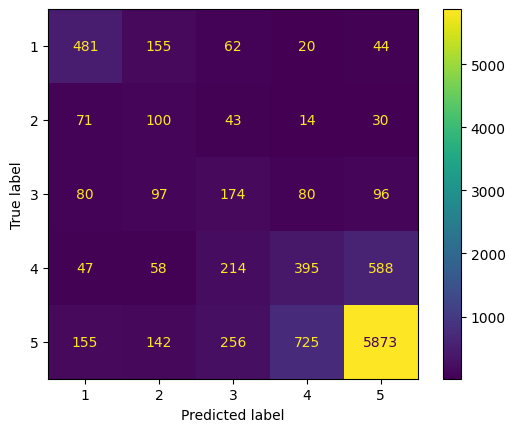

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

plt.show()

In [86]:
import random

# Define the number of random rows to view
n = 5

# Get random indices from the test set
random_idx = round(random.random() * len(X_test))


# Retrieve the corresponding sample and its information
sample_text = trunc.iloc[X_test.index[random_idx]]['review_body']
sample_tokenized = cleanly_tokenize(sample_text)
sample_real_stars = y_test.iloc[random_idx] 
sample_predicted_stars = predictions[random_idx]  

# Print the sample information
print("Sample Text:", sample_text)
print("Tokenized Text:", sample_tokenized)
print("Real Stars:", sample_real_stars)
print("Predicted Stars:", sample_predicted_stars)

Sample Text: LOVE IT!!! Easy to put on and it looks great on my car!
Tokenized Text: ['love', 'easy', 'put', 'look', 'great', 'car']
Real Stars: 5
Predicted Stars: 5


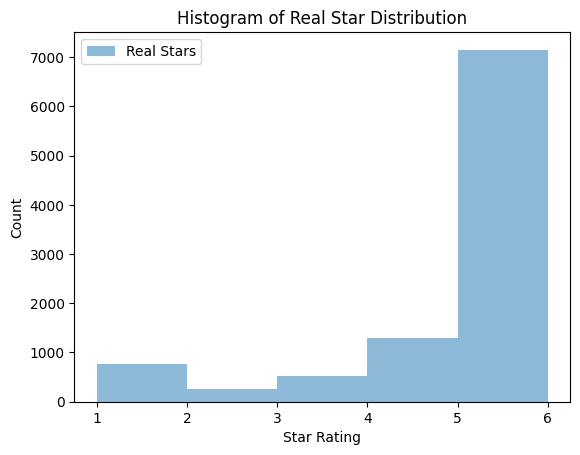

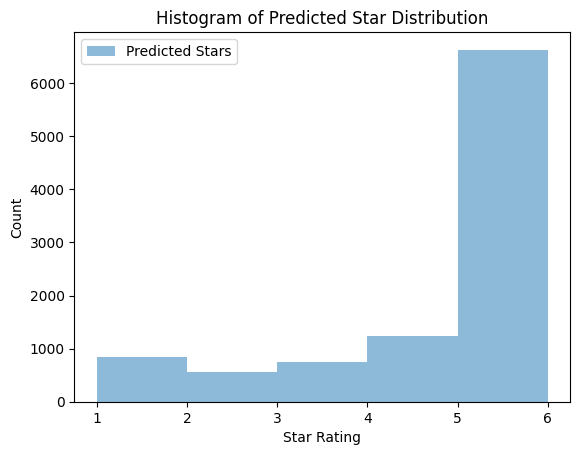

In [21]:
# Plot the histogram of real star distribution
plt.hist(y_test, bins=5, range=(1, 6), alpha=0.5, label='Real Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Real Star Distribution')
plt.legend()
plt.show()

# Plot the histogram of predicted star distribution
plt.hist(predictions, bins=5, range=(1, 6), alpha=0.5, label='Predicted Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Predicted Star Distribution')
plt.legend()
plt.show()


In [15]:
stars = data['star_rating']
print(len(stars.loc[stars == 1]))
print(len(stars.loc[stars == 2]))
print(len(stars.loc[stars == 3]))
print(len(stars.loc[stars == 4]))
print(len(stars.loc[stars == 5]))

40807
18588
30140
65431
324838


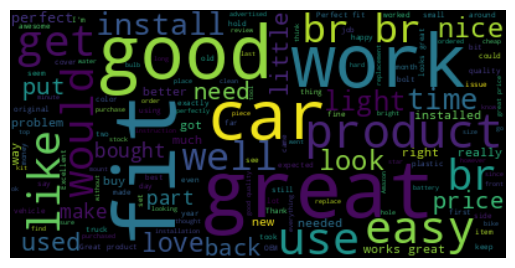

In [20]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

textt = " ".join(review for review in trunc['review_body'])
wordcloud = WordCloud(stopwords=stopwords.words()).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\Qcoret\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [19]:
def readFile(fileName):
  #Reads the file, the proper encoding is to prevent problems
  return pd.read_csv(fileName, encoding="utf−8")

In [21]:
punctuation = string.punctuation

def cleanData(data):
  #Replace missing data with "" in product_title
  data["product_title"] = data["product_title"].fillna("")

  n = len(data["review_body"])
  #for i in np.arange(n):
  #  data["review_body"][i] = BeautifulSoup(data["review_body"][i], "html.parser")

  #Remove the capital letters to prevent miscounting the frequency of words
  data["review_body"] = data["review_body"].str.lower()

  #Remove punctuation so that we can later split the data properly into words by only consider spaces
  data["review_body"] = data["review_body"].apply(lambda data: removePunctuation(data))

  testData = data["review_body"][0:100]
 
  stopwords = set(stopwords.words("english"))
  doc_string = testData.loc[0, "text"]
  print(doc_string)
  


def removePunctuation(text):
    return text.translate(str.maketrans('', '', punctuation))


In [22]:
def main():
  file = readFile("group_8_automotive_data.csv")
  #print(file.head())

  #Results below show that approximately all data is inserted,
  #except for product_title where approximately 0.0015% is missing
  #print(file.isnull().mean())

  #All variables are intepreted as 'object', except for 'customer_id' and 'star_rating' which are seen as 'int64'. This is fine if we consider the data

  #print(file.dtypes)

  #print(file.min())
  #print(file.max())


  cleanData(file)

main()

UnboundLocalError: local variable 'stopwords' referenced before assignment